# 读取数据并进行送入模型前准备

In [2]:
import pandas as pd
from darts import TimeSeries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## 加载数据并进行表连接

In [3]:
DATA_DIR = '../data/'

# 从文件中导入数据到dataframe中
def get_df(file, header=None):
    df = pd.read_csv(file, header=None)
    # df.columns = DF_HEADER.get(key, df.columns)
    df.columns = pd.read_csv("{}.header".format(file.split('.csv')[0])).columns if header is None else header
    return df

dfjob = get_df(DATA_DIR + 'pai_job_table.csv')
dftask = get_df(DATA_DIR + 'pai_task_table.csv')
dfinstance = get_df(DATA_DIR + 'pai_instance_table.csv')
dfsensor = get_df(DATA_DIR + 'pai_sensor_table.csv')
dfgroup = get_df(DATA_DIR + 'pai_group_tag_table.csv')
dfp_spec = get_df(DATA_DIR + 'pai_machine_spec.csv')
dfm_metric = get_df(DATA_DIR + 'pai_machine_metric.csv')

In [4]:
def get_dfia(dfi):
    dfi_s = dfi[dfi.start_time > 0][['job_name','task_name','start_time']].groupby(['job_name','task_name']).min()  # start_time
    dfi_e = dfi[dfi.end_time > 0][['job_name','task_name','end_time']].groupby(['job_name','task_name']).max()  # end_time
    dfi_m = dfi[(dfi.start_time > 0) & (dfi.end_time > 0)][['job_name','task_name','end_time','start_time']]
    dfi_m['runtime'] = dfi_m.end_time-dfi_m.start_time
    dfi_m = dfi_m.groupby(['job_name','task_name']).mean()[['runtime']].reset_index() # runtime
    dfi_u = dfi[['job_name','task_name','status']].drop_duplicates().groupby(['job_name','task_name']).max() # status
    dfia = dfi_u
    for df in [dfi_s, dfi_e, dfi_m]:
        dfia = dfia.merge(df, on=['job_name','task_name'], how='left')
    return dfia

def get_dfa(dft, dfj, dfi, dfg):
    print('dft + dfj ...')
    dfa = dft.merge(dfj, on=['job_name'], suffixes = ['','_j'])
    dfa.loc[dfa.start_time==0, 'start_time'] = np.nan
    dfa.loc[dfa.start_time==0, 'end_time'] = np.nan
    dfa['runtime'] = dfa.end_time - dfa.start_time
    print('dft + dfj + dfi ...')
    dfia = get_dfia(dfi)
    dfa = dfa.merge(dfia, on=['job_name','task_name'], suffixes=['','_i'])
    dfa['duration_min'] = dfa.runtime_i / 60  # duration of instances
    dfa['wait_time'] = dfa.start_time_i - dfa.start_time # task wait time
    dfa['start_date']=dfa.start_time.apply(pd.Timestamp, unit='s', tz='Asia/Shanghai') # task start time
    # dfa = dfa[dfa.status=='Terminated']
    print('dft + dfj + dfi + dfg ...')
    dfa = dfa.merge(dfg[[x for x in dfg.columns if x != 'user']], on='inst_id', how='left')  # reserve NaN ones by how='left'
    dfa.loc[dfa.group.isnull(),'group'] = dfa.loc[dfa.group.isnull(), 'user']  # fill group==NaN ones with user
    return dfa

dfa = get_dfa(dftask, dfjob, dfinstance, dfgroup)

dft + dfj ...
dft + dfj + dfi ...
dft + dfj + dfi + dfg ...


In [5]:
def get_dfiw(dfi):
    dfiw = dfi.sort_values(['status','start_time','end_time'])
    dfiw.drop_duplicates(subset=['worker_name'], keep='last', inplace=True)
    dfiw.dropna(subset=['worker_name'], inplace=True)
    dfiw['runtime'] = dfiw[(dfiw.start_time>0)&(dfiw.end_time>0)]['end_time'] \
                    - dfiw[(dfiw.start_time>0)&(dfiw.end_time>0)]['start_time']
    dfiw.loc[dfiw.start_time==0, 'start_time'] = np.nan
    dfiw.loc[dfiw.start_time==0, 'end_time'] = np.nan
    return dfiw

def get_dfw(dfi, dft, dfg):
    dfw = get_dfiw(dfi)
    dfw['start_date']=dfw.start_time.apply(pd.Timestamp, unit='s', tz='Asia/Shanghai')
    print('dfi + dft ...')
    dfw = dfw.merge(dft, on=['job_name','task_name'], how='left', suffixes=['', '_t'])
    print('dfi + dft + dfg ...')
    dfw = dfw.merge(dfg, on='inst_id', how='left')  # reserve NaN ones by how='left'
    dfw.loc[dfw.group.isnull(),'group'] = dfw.loc[dfw.group.isnull(), 'user']  # fill group==NaN ones with user
    return dfw

dfw = get_dfw(dfinstance, dftask, dfgroup)

dfi + dft ...
dfi + dft + dfg ...


In [6]:
dfws = dfw.merge(dfp_spec.drop(columns={'gpu_type'}), on='machine', how='left')
dfws = dfws.merge(dfsensor.drop(columns=['job_name','task_name','inst_id','machine']), on='worker_name')

In [7]:
dfas = dfws.groupby(['job_name','task_name'])[['cpu_usage','gpu_wrk_util','avg_mem','avg_gpu_wrk_mem','plan_cpu','plan_gpu','plan_mem','cap_cpu','cap_gpu','cap_mem']].sum()
dfas = dfa.drop(columns=['plan_cpu','plan_mem','plan_gpu']).merge(dfas, on=['job_name','task_name'])

## 按照模型要求调整Dataframe

#### 生成每分钟作业提交数的Dataframe

In [10]:
# 生成 min 列表示时间顺序
dfa['minofyear'] = dfa.start_date.apply(lambda c: (c.dayofyear * 24)*60 + (c.hour)*60 + c.minute)
# 按照分钟进行聚合 统计job的数量
df_job_of_min = dfa.groupby('minofyear').count()[['job_name']].reset_index()
# 再按照 min 顺序进行排序
df_job_of_min.sort_values("minofyear", inplace=True)

In [11]:
df_job_of_min.head()

,minofyear,job_name
0,10158.0,2
1,10520.0,2
2,10594.0,2
3,10782.0,2
4,10800.0,1


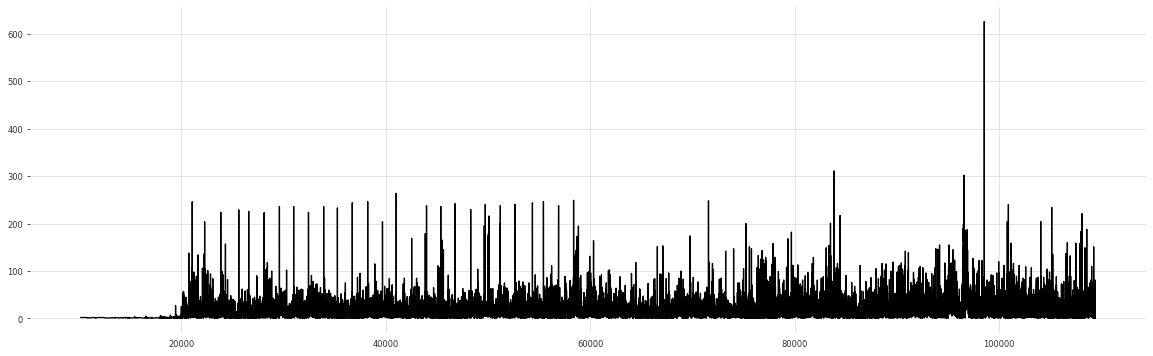

In [14]:

plt.figure(figsize=(20, 6))
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_columns', 100)
# matplotlib.rcParams.update({"font.size": 16,'lines.linewidth': 2.5})
plt.plot(df_job_of_min.minofyear, df_job_of_min.job_name)

在时间点20000后产生规律性，因此进行截取，用20000之后的数据

In [15]:
# 寻找第一个 天单位整点整分钟 进行数据截取 
# 根据上图显示 20000 之前的点感觉不连续
# 直接在 20000 分钟之后的第一个点取样
df_job_of_min = df_job_of_min[(df_job_of_min.minofyear>=20160)].set_index('minofyear')[['job_name']]
# 再将 index 进行转换
df_job_of_min = df_job_of_min.reset_index()

In [16]:
df_job_of_min.head()

,minofyear,job_name
0,20160.0,6
1,20161.0,7
2,20162.0,12
3,20163.0,3
4,20164.0,52


#### 生成每10分钟作业提交数的Dataframe

In [12]:
# 以10分钟为单位统计
df_minofyear_notnoll = dfa.dropna(subset=['minofyear'])
df_minofyear_notnoll['10minofyear'] =  df_minofyear_notnoll['minofyear'].apply(lambda c: int(c/10)*10)
dftcc_10min = df_minofyear_notnoll.groupby('10minofyear').count()[['job_name']].reset_index()
# 再按照 min 顺序进行排序
dftcc_10min.sort_values("10minofyear", inplace=True)

C:\Users\liduo\AppData\Local\Temp\ipykernel_1916\3641705392.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_minofyear_notnoll['10minofyear'] =  df_minofyear_notnoll['minofyear'].apply(lambda c: int(c/10)*10)


In [13]:
dftcc_10min.head()

,10minofyear,job_name
0,10150,2
1,10520,2
2,10590,2
3,10780,2
4,10800,1


同样选取20000以后的

In [17]:
dft_job_of_10min = dftcc_10min[(dftcc_10min['10minofyear']>=20160)].set_index('10minofyear')[['job_name']]
# 再将 index 进行转换
dft_job_of_10min = dft_job_of_10min.reset_index()

In [18]:
dft_job_of_10min.head()

,10minofyear,job_name
0,20160,148
1,20170,168
2,20180,87
3,20190,206
4,20200,205


# 对 df_job_of_year进行截取